# Sentence Reconstruction

### Deep Learning

### Matteo Fasulo

---

The purpose of this project is to take in input a sequence of words corresponding to a random permutation of a given english sentence, and reconstruct the original sentence.

The otuput can be either produced in a single shot, or through an iterative (autoregressive) loop generating a single token at a time.


CONSTRAINTS:
* No pretrained model can be used.
* The neural network models should have less the 20M parameters.
* No postprocessing should be done (e.g. no beamsearch)
* You cannot use additional training data.


BONUS PARAMETERS:

A bonus of 0-2 points will be attributed to incentivate the adoption of models with a low number of parameters.

---

# Libraries

In [ ]:
!pip install -U keras-nlp tensorflow datasets

In [1]:
import re, math, string

import numpy as np

from datasets import load_dataset

import matplotlib.pyplot as plt

import keras
from keras.layers import Embedding, Dense, Input
from keras.models import Model

from keras_nlp.layers import TransformerEncoder, TokenAndPositionEmbedding, TransformerDecoder

import tensorflow as tf
from tensorflow.keras.optimizers import AdamW

2024-06-11 20:18:44.000235: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-11 20:18:45.282052: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Due to heavy GPU memory consumption, Tensorflow has been used with the `memory_growth` option enabled as to not lock the entire GPU memory from the start.

In [2]:
# Set memory growth of GPU
physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)

# Parameters

First a couple of parameters are defined for the entire notebook.

- `SEQ_LEN` is the (maximum) length of the input sequence (eventually padded with zeros).
- `VOCAB_SIZE` is the size of the vocabulary (max 10000).

- `EMBEDDING_DIM` is the dimension of the word embeddings.
- `BATCH_SIZE` is the batch size.
- `EPOCHS` is the number of epochs for training.
- `NUM_ENC_LAYERS` is the number of layers of the encoder.
- `NUM_DEC_LAYERS` is the number of layers of the decoder.
- `NUM_HEADS` is the number of heads of the multihead attention mechanism.
- `LATENT_DIM` is the dimension of the latent space of the transformer (all the feedforward layers).

In [3]:
SEQ_LEN = 28
VOCAB_SIZE = 10000

BATCH_SIZE = 256
EPOCHS = 50

EMBEDDING_DIM = 128
LATENT_DIM = 1024
NUM_ENC_LAYERS = 6
NUM_DEC_LAYERS = 6
NUM_HEADS = 4

### Special Tokens

Before processing the text, a couple of special tokens are defined. These tokens are used to mark the beginning and end of the sentences as well as encoding comma which otherwise would be removed when preprocessing the text with punctuation removal.

In [4]:
class Tokens:
    START = '<start>'
    END = '<end>'
    COMMA = '<comma>'

# Dataset

The dataset is composed by sentences taken from the generics_kb dataset of hugging face. We restricted the vocabolary to the 10K most frequent words, and only took sentences making use of this vocabulary.

First we load the dataset and preprocess it by filtering only the sentences that have at least 9 words.

In [5]:
# Load the dataset
ds = load_dataset('generics_kb', trust_remote_code=True)['train']

# Filter out sentences that are too short
ds = ds.filter(lambda row: len(row["generic_sentence"].split(" ")) > 8)

## Preprocessing

Then we can add the start and end tokens to the sentences. Replacing comma with a special token to avoid its removal during preprocessing.

The entire process is vectorized to speed up the procedure.

In [6]:
# Define a vectorized function
vec_func = np.vectorize(
    lambda x: f'{Tokens.START} ' + x.replace(',', f' {Tokens.COMMA}') + f' {Tokens.END}')

# Apply the function to the 'generic_sentence' column of the DataFrame
corpus = vec_func(ds['generic_sentence'])

The custom preprocessing function is applied to the dataset. Instead of removing all the punctuation, we replace the comma with a special token as well as the greater and smaller signs. The rest of the punctuation is removed and all the sentences are lowercased.

In [7]:
def custom_preprocessing(text):
    """
    Preprocesses the given text by removing punctuation and converting it to lowercase.

    Args:
        text (str): The input text to be preprocessed.

    Returns:
        str: The preprocessed text.
    """
    chars = string.punctuation
    chars = chars.replace(",", "")
    chars = chars.replace("<", "")
    chars = chars.replace(">", "")
    # Remove punctuation
    text = tf.strings.regex_replace(text, '[%s]' % re.escape(chars), '')
    # Lowercase
    text = tf.strings.lower(text)
    return text

## Text Vectorization

After preprocessing the text, we can vectorize it using `TextVectorization` layer from tensorflow to convert the text to a sequence of integers. This operation is applied after adding the special tokens as to have them encoded as well into the vocabulary. The vocabulary size is 10K and if the sentences are shorter than the maximum length, they are padded with zeros by means of `output_sequence_length` and the `pad_to_max_tokens` parameters.

In this case, the output will be integers each of them representing a word in the vocabulary.

In [8]:
# Create a TextVectorization layer
tokenizer = tf.keras.layers.TextVectorization(
    max_tokens=VOCAB_SIZE,
    standardize=custom_preprocessing,
    output_sequence_length=SEQ_LEN,
    output_mode='int',
    pad_to_max_tokens=True,
)

# Adapt the layer to the dataset
tokenizer.adapt(corpus)

2024-06-11 20:18:58.467831: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1928] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 8251 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3080, pci bus id: 0000:01:00.0, compute capability: 8.6


We can also inspect the vocabulary and the first 10 most frequent words.

In [9]:
vocab = tokenizer.get_vocabulary()
vocab[:10]

['', '[UNK]', '<start>', '<end>', 'the', 'of', 'and', '<comma>', 'is', 'to']

## Text Detokenizer

To convert the integers back to text, we can define a custom detokenizer function that takes in input the integers and returns the corresponding text. This function is used to convert the output of the model back to text.

In [10]:
class TextDetokenizer:
    def __init__(self, vectorize_layer):
        self.vectorize_layer = vectorize_layer
        vocab = self.vectorize_layer.get_vocabulary()
        self.index_to_word = {index: word for index, word in enumerate(vocab)}

    def __detokenize_tokens(self, tokens):
        def check_token(t):
            if t == 2:
                s = "<start>"
            elif t == 3:
                s = "<end>"
            elif t == 7:
                s = "<comma>"
            else:
                s = self.index_to_word.get(t, '[UNK]')
            return s

        return ' '.join([check_token(token) for token in tokens if token != 0])

    def __call__(self, batch_tokens):
        return [self.__detokenize_tokens(tokens) for tokens in batch_tokens]

In [11]:
detokenizer = TextDetokenizer(tokenizer)

### Problem with OOV

The model will not be able to generate words that are not in the vocabulary. To overcome this issue, we can remove from our dataset all the sentences that contain words not in the vocabulary. This way we can avoid the model to generate OOV tokens.

In the following cell, we first encode all the sentences and then check if there are more than 1 [UNK] token in the sentence. If so, we discard the sentence.

In [12]:
# Convert the text to tokens
sentences = tokenizer( corpus ).numpy()

# Find sentences with more than one [UNK] token
mask = np.sum( (sentences==1), axis=1) >= 1

# Remove them from the dataset
original_data = np.delete( sentences, mask , axis=0)

original_data.shape

(241194, 28)

## Data Generator

The original data generator was modified changing the inheriting class from `keras.utils.Sequence` to `keras.utils.PyDataset` which is supported in Keras 3 for passing directly the data to the model `fit` method.

Changes applied to the generator:

- `math.ceil` is used during the computation of the number of batches of the dataset.
- `__getitem__` now returns a tuple `(enc_in, dec_in), dec_out` with encoder and decoder inputs and decoder output.

More in detail, the generator returns the following:

* The input of the encoder is the shuffled sentence.
* the input of the decoder is the original sentence. 
* The output of the decoder is the original sentence shifted by one position (including end token but not start token).

In [13]:
class DataGenerator(keras.utils.PyDataset):
    def __init__(self, data, batch_size=32, shuffle=True, seed=42, **kwargs):
        super().__init__(**kwargs)
        self.data = data
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.seed = seed
        self.on_epoch_end()

    def __len__(self):
        return math.ceil(len(self.data) / self.batch_size)

    def __getitem__(self, index):
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        data_batch = np.array([self.data[k] for k in indexes], dtype=np.int16)
        # copy of ordered sequences
        result = np.copy(data_batch)

        # shuffle only the relevant positions for each batch
        for i in range(data_batch.shape[0]):
            np.random.shuffle(data_batch[i, 1:data_batch[i].argmin() - 1])

        # (encoder_input, decoder_input), decoder_output
        encoder_input = data_batch
        decoder_input = np.copy(result)
        decoder_output = np.copy(result)
        decoder_output = decoder_output[:, 1:]

        # Add a column of zeros at the end
        decoder_output = np.pad(decoder_output, [[0, 0], [0, 1]], mode='constant')

        return (encoder_input, decoder_input), decoder_output

    def on_epoch_end(self):
        self.indexes = np.arange(len(self.data))
        if self.shuffle:
            if self.seed is not None:
                np.random.seed(self.seed)
            np.random.shuffle(self.indexes)

## Shuffle data

The entire dataset is shuffled and split into training and validation sets. The training set contains 220K sentences and the validation set 15K sentences. Both the generators share the same batch size for simplicity.

In [14]:
# Make a random permutation of training and test set
np.random.seed(42)
# Shuffle the all data
shuffled_indices = np.random.permutation(len(original_data))
shuffled_data = original_data[shuffled_indices]

In [15]:
# Split the data into training and validation sets
train_generator = DataGenerator(shuffled_data[:220000], batch_size=BATCH_SIZE)
val_generator = DataGenerator(shuffled_data[220000:235000], batch_size=BATCH_SIZE)

# Metrics

Let s be the source string and p your prediction. The quality of the results will be measured according to the following metric:

1.  look for the longest substring w between s and p
2.  compute |w|/max(|s|,|p|)

If the match is exact, the score is 1.

When computing the score, the start and end tokens are not considered.

In [16]:
from difflib import SequenceMatcher


def score(s, p):
    match = SequenceMatcher(None, s, p).find_longest_match()
    # print(match.size)
    return (match.size/max(len(p), len(s)))

Example of the metric:

In [17]:
original = "at first henry wanted to be friends with the king of france"
generated = "henry wanted to be friends with king of france at the first"

print("your score is ", score(original, generated))

your score is  0.5423728813559322


# Model

The model is composed by an encoder-decoder architecture with a transformer as the main component. The encoder is composed by a stack of `NUM_ENC_LAYERS` layers, each of them composed by a multihead attention mechanism and a feedforward layer. The decoder is composed by a stack of `NUM_DEC_LAYERS` layers, each of them composed by a multihead attention mechanism, a feedforward layer and an additional multihead attention mechanism that takes the encoder output as input. 

The output of the decoder is passed through a dense layer without activation function to produce the logits.

Due to the fact that the input sequence is shuffled, the encoder does not have a Positional Encoding layer but just an Embedding layer. The decoder instead has both the Embedding layer and the Positional Encoding layer as to take into account the position of the words in the (correct) sentence.

In [18]:
def create_transformer(embedding_dim, number_encoding_layers, number_decoding_layers, number_heads, dff, seq_len, vocab_size, dropout_rate):
    """
    Create a transformer model for sentence reconstruction.

    Args:
        embedding_dim (int): The dimensionality of the token embeddings.
        number_encoding_layers (int): The number of encoding layers in the transformer.
        number_decoding_layers (int): The number of decoding layers in the transformer.
        number_heads (int): The number of attention heads in the transformer.
        dff (int): The dimensionality of the feed-forward network in the transformer.
        seq_len (int): The length of the input sequences.
        vocab_size (int): The size of the vocabulary.
        dropout_rate (float): The dropout rate to apply in the transformer.

    Returns:
        model (keras.Model): The created transformer model.

    """
    # Encoder input
    enc_id_input = Input(
      shape=(seq_len,),
      name="token_id_enc",
    )

    # Decoder input
    dec_id_input = Input(
        shape=(seq_len,),
        name="token_id_dec",
    )

    # Encoder Token Embedding, no Position Embedding since the input is shuffled
    emb_enc = Embedding(
        input_dim=vocab_size,
        output_dim=embedding_dim
        )(enc_id_input)

    # Stack the encoder layers
    encoder_layers = []
    for i in range(number_encoding_layers):
        encoder_layer = TransformerEncoder(
        num_heads=number_heads,
        intermediate_dim=dff,
        dropout=dropout_rate,
        name="encoder"+str(i)
        )
        encoder_layers.append(encoder_layer)

    # Apply encoder layers
    encoder_seq = emb_enc
    for encoder_layer in encoder_layers:
        encoder_seq = encoder_layer(encoder_seq)

    # Decoder Token and Position Embedding
    emb_dec = TokenAndPositionEmbedding(
      vocabulary_size=vocab_size,
      sequence_length=seq_len,
      embedding_dim=embedding_dim,
      name="dec_emb",
    )(dec_id_input)
    # Stack the decoder layers
    decoder_layers = []
    for i in range(number_decoding_layers):
        decoder_layer = TransformerDecoder(
        num_heads=number_heads,
        intermediate_dim=dff,
        dropout=dropout_rate,
        name="decoder"+str(i)
        )
        decoder_layers.append(decoder_layer)
    # Apply decoder layers
    decoder_seq = emb_dec
    for decoder_layer in decoder_layers:
        decoder_seq = decoder_layer(encoder_sequence=encoder_seq, decoder_sequence=decoder_seq)

    # Output layer with simple Dense layer
    outputs = Dense(vocab_size)(decoder_seq)

    model = Model(inputs=[enc_id_input, dec_id_input], outputs=outputs)
    model.summary()
    return model

## Learning Rate Scheduler

THe following learning rate scheduler from the original Transformer paper is used. The learning rate is increased linearly in the first `warmup_steps` steps and then decreased proportionally to the inverse square root of the step number.

In [19]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
  def __init__(self, d_model, warmup_steps=4000):
    super().__init__()

    self.d_model = d_model
    self.warmup_steps = warmup_steps

  def __call__(self, step):
    step = tf.cast(step, dtype=tf.float32)
    arg1 = tf.math.rsqrt(step)
    arg2 = step * tf.cast((self.warmup_steps ** -1.5), dtype=tf.float32)
    
    return tf.math.rsqrt(tf.cast(self.d_model, dtype=tf.float32)) * tf.math.minimum(arg1, arg2)

## Loss Function and Accuracy

Even if the we pass to the model the sequences as tensors of integers, the loss function is computed on the one-hot encoded version of the (true) sequence. This allows to introduce the label smoothing technique to avoid overfitting as described in the [paper](https://arxiv.org/abs/1706.03762).

Regarding the accuracy, it is a masked accuracy where we check if the predicted token is equal to the true token only if the true token is not a padding token and the operation is performed on the entire sequence element-wise.

For both the loss and the accuracy, an average is then computed to get a single scalar value.

In [20]:
def masked_loss(label, pred):
    """
    Calculates the masked loss for a given label and prediction.

    Args:
        label: The true label values.
        pred: The predicted values.

    Returns:
        The masked loss value.

    """
    label = tf.cast(label, tf.int64)
    mask = label != 0
    loss_object = tf.keras.losses.CategoricalCrossentropy(from_logits=True, reduction='none', label_smoothing=0.1)
    label = tf.one_hot(label, depth=VOCAB_SIZE)
    loss = loss_object(label, pred)

    mask = tf.cast(mask, dtype=loss.dtype)
    loss *= mask

    res = tf.reduce_sum(loss)/tf.reduce_sum(mask)

    return res


def masked_accuracy(label, pred):
    """
    Calculates the masked accuracy of the predicted labels.

    Args:
        label (tf.Tensor): The true labels.
        pred (tf.Tensor): The predicted labels.

    Returns:
        tf.Tensor: The masked accuracy.

    """
    pred = tf.argmax(pred, axis=2)
    label = tf.cast(label, pred.dtype)
    # Match is when the prediction is equal to the label
    match = tf.math.equal(label, pred)

    mask = tf.math.logical_not(tf.math.equal(label, 0))

    match = match & mask

    match = tf.cast(match, dtype=tf.float32)
    mask = tf.cast(mask, dtype=tf.float32)
    return tf.reduce_sum(match)/tf.reduce_sum(mask)

## Compile and run the model

Now we can instantiate the model and compile it using the AdamW optimizer and the custom loss function. The model is then trained for `EPOCHS` epochs using the training and validation generators.

A small dropout is applied to the output of the encoder and the output of the decoder to avoid overfitting.

AdamW parameters are set to the one from the original paper. To better avoid the overfitting, the model integrates weight decay.

In [21]:
dropout_rate = 0.1
keras_transformer = create_transformer(EMBEDDING_DIM, NUM_ENC_LAYERS, NUM_DEC_LAYERS, NUM_HEADS, LATENT_DIM, SEQ_LEN, VOCAB_SIZE, dropout_rate)

learning_rate = CustomSchedule(d_model=EMBEDDING_DIM, warmup_steps=4000)
optimizer = AdamW(learning_rate=learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9, weight_decay = 0.005)
keras_transformer.compile(optimizer=optimizer, loss=masked_loss, metrics=[masked_accuracy])

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ token_id_enc        │ (None, 28)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 28, 128)   │  1,280,000 │ token_id_enc[0][… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder0            │ (None, 28, 128)   │    329,856 │ embedding[0][0]   │
│ (TransformerEncode… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder1            │ (None, 28, 128)   │    329,856 │ encoder0[0][0]    │
│ (TransformerEncode… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder2            │ (None, 28, 128)   │    329,856 │ encoder1[0][0]    │
│ (TransformerEncode… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder3            │ (None, 28, 128)   │    329,856 │ encoder2[0][0]    │
│ (TransformerEncode… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ token_id_dec        │ (None, 28)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder4            │ (None, 28, 128)   │    329,856 │ encoder3[0][0]    │
│ (TransformerEncode… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dec_emb             │ (None, 28, 128)   │  1,283,584 │ token_id_dec[0][… │
│ (TokenAndPositionE… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder5            │ (None, 28, 128)   │    329,856 │ encoder4[0][0]    │
│ (TransformerEncode… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder0            │ (None, 28, 128)   │    396,160 │ dec_emb[0][0],    │
│ (TransformerDecode… │                   │            │ encoder5[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder1            │ (None, 28, 128)   │    396,160 │ decoder0[0][0],   │
│ (TransformerDecode… │                   │            │ encoder5[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder2            │ (None, 28, 128)   │    396,160 │ decoder1[0][0],   │
│ (TransformerDecode… │                   │            │ encoder5[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder3            │ (None, 28, 128)   │    396,160 │ decoder2[0][0],   │
│ (TransformerDecode… │                   │            │ encoder5[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder4            │ (None, 28, 128)   │    396,160 │ decoder3[0][0],   │
│ (TransformerDecode… │                   │            │ encoder5[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder5            │ (None, 28, 128)   │    396,160 │ decoder4[0][0],   │
│ (TransformerDecode… │                   │            │ encoder5[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 28, 10000) │  1,290,000 │ decoder5[0][0]  

 Total params: 8,209,680 (31.32 MB)

 Trainable params: 8,209,680 (31.32 MB)

 Non-trainable params: 0 (0.00 B)

As we can see the model has less than 10M parameters (indeed satisfying the constraints) and the training is quite fast.

To have an estimate of how the training is going, we can use the validation generator to compute the loss and accuracy on the validation set.

A couple of callbacks were also added to ensure the model is saved only if the validation loss is decreasing and for logging the training history.

EarlyStopping, in particular, is used to stop the training if the validation loss does not decrease for 5 epochs.

In [22]:
name = 'keras_transformer_custom_loss_v3'

history = keras_transformer.fit(
    train_generator,
    epochs=EPOCHS,
    validation_data=val_generator,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor="val_loss", mode = "min", patience=5, restore_best_weights=True),
        tf.keras.callbacks.ModelCheckpoint(f'{name}.weights.h5', verbose=1, save_best_only=True, save_weights_only=True),
        tf.keras.callbacks.CSVLogger(f"{name}.csv")
    ]
)

Epoch 1/50


I0000 00:00:1718137195.587420  416045 service.cc:145] XLA service 0x76e98c001dd0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1718137195.587458  416045 service.cc:153]   StreamExecutor device (0): NVIDIA GeForce RTX 3080, Compute Capability 8.6
2024-06-11 20:19:57.799962: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-06-11 20:20:05.345917: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8907
I0000 00:00:1718137278.829380  416199 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_10', 652 bytes spill stores, 824 bytes spill loads

I0000 00:00:1718137278.930345  416203 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_411', 412 bytes spill stores, 416 bytes spill loads

I0000 00:

847/860 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 8.1357 - masked_accuracy: 0.1326

I0000 00:00:1718137482.373940  416781 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_672', 4 bytes spill stores, 4 bytes spill loads

I0000 00:00:1718137482.910320  416777 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_672', 272 bytes spill stores, 272 bytes spill loads

I0000 00:00:1718137486.217036  416780 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_411', 260 bytes spill stores, 268 bytes spill loads

I0000 00:00:1718137486.763522  416781 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_674', 212 bytes spill stores, 212 bytes spill loads

I0000 00:00:1718137486.914432  416784 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_674', 52 bytes spill stores, 52 bytes spill loads

I0000 00:00:1718137493.011333  

860/860 ━━━━━━━━━━━━━━━━━━━━ 0s 239ms/step - loss: 8.1179 - masked_accuracy: 0.1342

I0000 00:00:1718137585.152822  417220 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_10', 192 bytes spill stores, 192 bytes spill loads

I0000 00:00:1718137586.218012  417220 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_10', 28 bytes spill stores, 20 bytes spill loads

I0000 00:00:1718137587.294935  417222 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_10', 476 bytes spill stores, 280 bytes spill loads

I0000 00:00:1718137588.305128  417222 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_10', 4 bytes spill stores, 4 bytes spill loads




Epoch 1: val_loss improved from inf to 5.00559, saving model to keras_transformer_custom_loss_v3.weights.h5
860/860 ━━━━━━━━━━━━━━━━━━━━ 445s 264ms/step - loss: 8.1166 - masked_accuracy: 0.1343 - val_loss: 5.0056 - val_masked_accuracy: 0.4172
Epoch 2/50
859/860 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 4.5734 - masked_accuracy: 0.4690
Epoch 2: val_loss improved from 5.00559 to 3.31271, saving model to keras_transformer_custom_loss_v3.weights.h5
860/860 ━━━━━━━━━━━━━━━━━━━━ 41s 47ms/step - loss: 4.5724 - masked_accuracy: 0.4692 - val_loss: 3.3127 - val_masked_accuracy: 0.6287
Epoch 3/50
860/860 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 3.1928 - masked_accuracy: 0.6407
Epoch 3: val_loss improved from 3.31271 to 2.64583, saving model to keras_transformer_custom_loss_v3.weights.h5
860/860 ━━━━━━━━━━━━━━━━━━━━ 41s 47ms/step - loss: 3.1926 - masked_accuracy: 0.6407 - val_loss: 2.6458 - val_masked_accuracy: 0.7193
Epoch 4/50
859/860 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 2.6284 - masked_a

## Loss and Accuracy Plot

The training history is shown below in graphs showing loss and accuracy on the training and validation sets.
Also, the learning rate schedule is shown with respect to the number of steps.

total steps:  4608
total epochs:  18


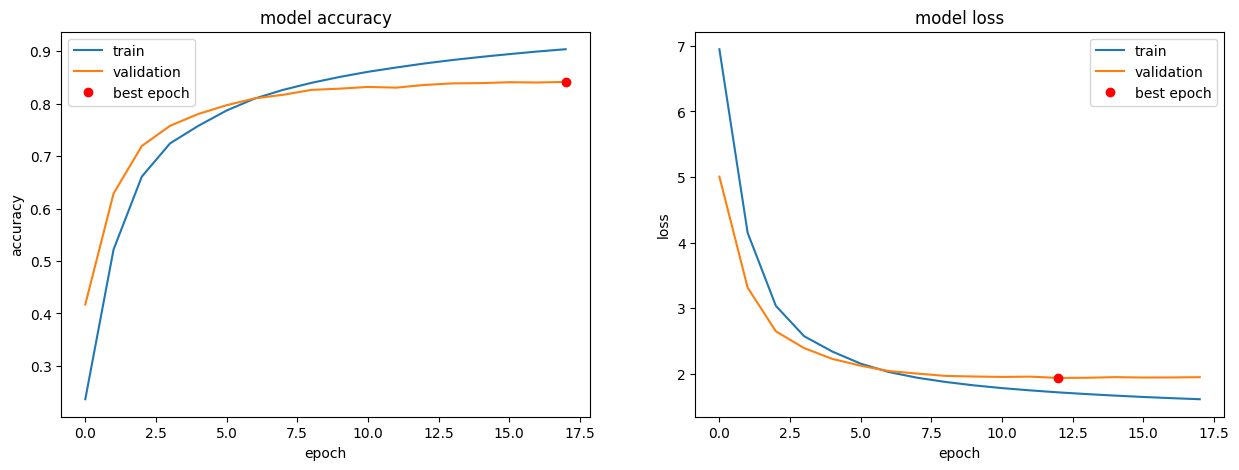

In [27]:
#print number of steps and epochs done
print("total steps: ", len(history.history["loss"])*BATCH_SIZE)
print("total epochs: ", len(history.history["loss"]))
#plot accuracy
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.plot(history.history['masked_accuracy'], label="train")
plt.plot(history.history['val_masked_accuracy'], label="validation")
#draw a red point at the best epoch for validation accuracy
best_epoch=np.argmax(history.history['val_masked_accuracy'])
plt.plot(best_epoch,history.history['val_masked_accuracy'][best_epoch],'ro', label="best epoch")
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend()
#plot loss
plt.subplot(1,2,2)
plt.plot(history.history['loss'], label="train")
plt.plot(history.history['val_loss'], label="validation")
#draw a red point at the best epoch for validation loss
best_epoch=np.argmin(history.history['val_loss'])
plt.plot(best_epoch,history.history['val_loss'][best_epoch],'ro', label="best epoch")
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend()
plt.show()

The model showed a good performance on the validation set with respect to the training set, and the loss decreased quite fast. However, starting from epoch 12 the loss on the validation set started to increase, and the training was stopped at epoch 17 due to the EarlyStopping callback.

## Testing on unseen data

Let's test the model on some unseen data. We can start taking a sentence from the dataset in the very ending part (235000+) and choose randomly 3k instances.

In [24]:
# Choose a random subset of 3k samples to evaluate the model

start_idx = 235000
end_idx = shuffled_data.shape[0]

random_sample = np.random.choice(np.arange(start_idx, end_idx), size=3000, replace=False) # Without replacement

Then we can take the indices of the randomly selected instances and use them to extract the sentences from the dataset. 

In [25]:
test_generator = DataGenerator(shuffled_data[random_sample], batch_size=32)

## Computing score

To test the performance of the model, we can query the test generator. Then the testing phase involves query multiple times the model with the `predict` method and then compute the score. Each time we predict the next token and we use the tokens found so far as input for the next prediction (autoregressive loop). In this way we can generate the entire sentence token by token. 

In [30]:
scores = []

for inputs, _ in test_generator:
    encoder_in, decoder_in = inputs
    current_batch_size = encoder_in.shape[0]
    
    output_array = tf.TensorArray(dtype=tf.int64, size=0, dynamic_size=True)
    start = np.array(vocab.index(Tokens.START), ndmin=1)
    output_array = output_array.write(0, tf.tile(start, [current_batch_size]))

    for i in range(SEQ_LEN):
        output = tf.transpose(output_array.stack())
        predictions = keras_transformer.predict((encoder_in, output), verbose=0)

        predictions = predictions[:, -1:, :]

        predicted_id = tf.argmax(predictions, axis=-1)

        output_array = output_array.write(i+1, predicted_id[:, 0])

        end_mask = tf.reduce_any(tf.equal(predicted_id, vocab.index(Tokens.END)), axis=-1)
        if tf.reduce_all(end_mask):
            break

    output = tf.transpose(output_array.stack())
    output = output.numpy()
    output = detokenizer(output)
    y = detokenizer(decoder_in)

    for predicted, real in zip(output, y):
        predicted = predicted.replace(Tokens.START, "").replace(Tokens.END, "").replace(f" {Tokens.COMMA}", ",").strip()
        real = real.replace(Tokens.START, "").replace(Tokens.END, "").replace(f" {Tokens.COMMA}", ",").strip()
        scores.append(score(real, predicted))

print("\nNumber of samples: ", len(scores))
print("Average score: ", np.mean(scores))
print("Standard deviation: ", np.std(scores))


Number of samples:  3000
Average score:  0.5099087170938909
Standard deviation:  0.280557539956132


## Results

### Score ~0.51 with std 0.28 evaluated on 3000 instances of the test set (randomly selected).

## Conclusions

The proposed Transformer model showed a good performance in reconstructing the original sentence from a shuffled version of it.

Other approaches like Seq2Seq with LSTM encoder and decoder failed to caputer long-term dependencies and syntactic structures of the sentences. The transformer model instead showed a good performance in this task.

The proposed Transformer model has less than 10M parameters and is able to achieve a good performance on the test set. A more hyperparametrized model could achieve better results but would not satisfy the constraints of the project.

The model could be further improved by increasing the number of layers and the dimension of the latent space, but this would require more parameters and would not satisfy the constraints of the project. Moreover, the `EMBEDDING_DIM` parameter had a cruicial role in determining the number of parameters of the model. Increasing the embedding dimension was leading to a Transformer of around 15M parameters having barely a +0.01 increase in the score.

Among the two solutions, I choose the one with the lowest number of parameters as it was more challenging and interesting to work with.

> Note: The model could be further improved by injecting into the loss function some preference over longer sequences rather than just the correct token in the correct position. This could be done by adding a term to the loss function that penalizes the model for generating shorter sequences. This would require a custom loss function (still differentiable) and would be a good improvement to the model. I tried this approach but it required more time to train the model and indeed it was just a +0.01 on the score (not worth the time). The idea behind this intuition was that the model could have been more penalized for generating shorter sequences and thus it would have been forced to generate longer sequences and it was all done by using the 1-complement of the `score` function added as a multiplicative factor to the loss value.